- *Ali Loloee Jahromi* - *ali.loloeejahromi@studio.unibo.it*
- *Fatemeh Izadinejad* - *fatemeh.izadinejad@studio.unibo.it*

# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#2


In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [2]:
import os
import csv
import copy
import random
from pathlib import Path
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import Tensor
from torchsummary import summary
from torch.optim import Adam, lr_scheduler, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision.models import resnet18, ResNet18_Weights

## Availability of GPU

In [3]:
gpu_avail = torch.cuda.is_available()
device = torch.device("cuda") if gpu_avail else torch.device("cpu")
print(f"Is the GPU available? {gpu_avail}")
print(f"Device: {device}")

Is the GPU available? True
Device: cuda


## Utilities
The methods here are prerequisites for both part1 and part2. So, do not forget to run this code. A proper docstring is written for each function, to clearify the task they are supposed to handle.

In [4]:
def fix_random(seed: int) -> None:
    """
    Fix all the possible sources of randomness using the provided seed.

    Args:
    - seed (int): The seed to use for fixing randomness across different libraries.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def print_directory_structure(directory, indent=0):
    """
    Prints a tree structure of all folders and sub-folders located inside the specified directory.

    This function recursively traverses the given directory and prints its structure in a tree format.

    Parameters:
    - directory (str): The path of the directory to print the structure of.
    - indent (int, optional): The indentation level for the current directory. Default is 0.
    """

    print(' ' * indent + os.path.basename(directory) + '/')
    indent += 2

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            print_directory_structure(item_path, indent)

def train(
        model, train_loader, val_loader, criterion, optimizer,
        scheduler=None, num_epochs=20, model_save_path='best_model.pth',
        patience=0, device=device
        ):
    """
    Trains the model

    This function performs the following tasks during training:
    - Prints the "Epoch", "Training Loss", "Training Accuracy", "Validation Loss", and "Validation Accuracy".
    - Saves the model with the lowest validation loss.
    - Implements early stopping if validation loss does not improve and patience is greater than 0.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation data.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimization algorithm.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler.
        num_epochs (int, optional): Number of epochs to train the model. Default is 20.
        model_save_path (str, optional): Path to save the model with the lowest validation loss. Default is 'best_model.pth'.
        patience (int, optional): Number of epochs to wait for improvement in validation loss before stopping. Default is 0.

    Returns:
        tuple: Contains four lists tracking the training and validation loss and accuracy over epochs:
            - train_loss_history (list): Training loss for each epoch.
            - train_acc_history (list): Training accuracy for each epoch.
            - val_loss_history (list): Validation loss for each epoch.
            - val_acc_history (list): Validation accuracy for each epoch.
    """

    # model.to(device)  ## model is already in the 'device' when entering this function

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Check for early stopping
        if patience > 0 and epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_save_path)

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def find_max_and_index(lst):
    if not lst:
        return None, None

    max_element = max(lst)
    max_index = lst.index(max_element)

    return max_element, max_index+1

def find_min_and_index(lst):
    if not lst:
        return None, None

    min_element = min(lst)
    min_index = lst.index(min_element)

    return min_element, min_index+1

def evaluate_model(model, model_name, test_loader, print_result=True, device=device):
    """
    Evaluates the performance of a trained model on a test dataset.

    This function loads the model's state from a specified file, evaluates its performance
    on the provided test data, and prints the test accuracy.

    Parameters:
    - model (torch.nn.Module): The neural network model to be evaluated.
    - model_name (str): The file path to the saved model state dictionary.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.

    Returns:
    - None (test accuracy is printed)
    """

    model.to(device)

    state_dict = torch.load(model_name)
    model.load_state_dict(state_dict)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total
    if print_result :
        print(f'Test Accuracy: {test_acc:.4f}')
    else :
        return test_acc

def plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history):
    """
    Plots the training and validation loss and accuracy over epochs.

    This function creates two subplots:
    - The first subplot displays the training and validation loss over the epochs.
    - The second subplot displays the training and validation accuracy over the epochs.

    Parameters:
    - train_loss_history (list): List of training loss values for each epoch.
    - train_acc_history (list): List of training accuracy values for each epoch.
    - val_loss_history (list): List of validation loss values for each epoch.
    - val_acc_history (list): List of validation accuracy values for each epoch.

    Returns:
    - None
    """
    epochs = range(1, len(train_loss_history) + 1)

    # Identify the epoch with the best validation loss and accuracy
    best_val_loss_epoch = val_loss_history.index(min(val_loss_history)) + 1
    best_val_acc_epoch = val_acc_history.index(max(val_acc_history)) + 1

    plt.figure(figsize=(14, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, 'b', label='Training Loss')
    plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
    plt.scatter(best_val_loss_epoch, val_loss_history[best_val_loss_epoch - 1], color='g', s=100, zorder=5, label='Best Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_history, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc_history, 'r', label='Validation Accuracy')
    plt.scatter(best_val_acc_epoch, val_acc_history[best_val_acc_epoch - 1], color='g', s=100, zorder=5, label='Best Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

class GroceryStoreDataset(Dataset):
    """
    Custom dataset class for the Grocery Store dataset.

    Args:
        split (str): The split of the dataset (e.g., 'train', 'val', 'test').
        transform (torchvision.transforms): A function/transform to apply to the images. Default is None.

    Attributes:
        root (Path): The root directory of the dataset.
        split (str): The split of the dataset (e.g., 'train', 'val', 'test').
        paths (List[str]): List of file paths to images.
        labels (List[int]): List of corresponding labels for the images.
        transform (torchvision.transforms): A function/transform to apply to the images.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Retrieves the idx-th sample from the dataset.
        read_file(): Reads the file containing image paths and labels.
        get_num_classes(): Returns the number of unique classes in the dataset.
    """

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                path, _, label = line.strip().split(", ")
                paths.append(path)
                labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

def get_data_loaders(train_transform, val_test_transform, batch_size=32):
    """
    Prepares and returns DataLoader objects for training, validation, and test datasets.

    This function initializes the training, validation, and test datasets with the specified transformations and dataset splits.
    It then creates DataLoader objects for each dataset, setting batch size and shuffling options accordingly.

    Args:
        train_transform (callable): Transformations to apply to the training dataset.
        val_test_transform (callable): Transformations to apply to both validation and test datasets.
        batch_size (int, optional): Number of samples per batch in each DataLoader. Default is 32.

    Returns:
        tuple: Contains three DataLoader objects:
            - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset, with shuffling enabled.
            - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset, without shuffling.
            - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset, without shuffling.
    """
    train_dataset = GroceryStoreDataset(split='train', transform=train_transform)
    val_dataset = GroceryStoreDataset(split='val', transform=val_test_transform)
    test_dataset = GroceryStoreDataset(split='test', transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def visualize_samples_from_folder(folder_path: str, num_samples: int = 5) -> None:
    """
    Visualizes a specified number of image samples from a folder.

    Args:
        folder_path (str): The path to the folder containing the images.
        num_samples (int, optional): The number of samples to visualize. Default is 5.

    Returns:
        None
    """
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_files = image_files[:num_samples]
    image_sizes = []

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for ax, image_file in zip(axes, image_files):
        img_path = os.path.join(folder_path, image_file)
        img = Image.open(img_path)
        image_sizes.append(img.size)
        ax.imshow(img)
        ax.axis('off')

    plt.show()
    return image_sizes

def plot_performance_histogram(performance):
    """
    Plots a bar chart comparing test and validation accuracy for each model.

    Parameters:
    performance (dict): A dictionary where keys are model names and values are 
                        dictionaries containing 'test_accuracy' and 'val_accuracy' for each model.
    """
    models = list(performance.keys())
    test_accuracies = [performance[model]['test_accuracy'] for model in models]
    val_accuracies = [performance[model]['val_accuracy'] for model in models]

    # Define bar width and positions
    bar_width = 0.35
    index = np.arange(len(models))

    fig, ax = plt.subplots(figsize=(10, 6))
    
    test_bars = ax.bar(index, test_accuracies, bar_width, label='Test Accuracy', color='orange')
    val_bars = ax.bar(index + bar_width, val_accuracies, bar_width, label='Validation Accuracy', color='green')

    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Test and Validation Accuracy for Each Model')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models)
    ax.legend()

    for bar in test_bars + val_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [5]:
fix_random(42)

## The Dataset
Before processing to find solutions for part1 and part2 of this assignment, it is good to have an understanding of the dataset

### The structure of the Dataset

In [6]:
train_folder_path = "GroceryStoreDataset/dataset/train"
print_directory_structure(train_folder_path)

train/
  Fruit/
    Apple/
      Golden-Delicious/
      Granny-Smith/
      Pink-Lady/
      Red-Delicious/
      Royal-Gala/
    Avocado/
    Banana/
    Kiwi/
    Lemon/
    Lime/
    Mango/
    Melon/
      Cantaloupe/
      Galia-Melon/
      Honeydew-Melon/
      Watermelon/
    Nectarine/
    Orange/
    Papaya/
    Passion-Fruit/
    Peach/
    Pear/
      Anjou/
      Conference/
      Kaiser/
    Pineapple/
    Plum/
    Pomegranate/
    Red-Grapefruit/
    Satsumas/
  Packages/
    Juice/
      Bravo-Apple-Juice/
      Bravo-Orange-Juice/
      God-Morgon-Apple-Juice/
      God-Morgon-Orange-Juice/
      God-Morgon-Orange-Red-Grapefruit-Juice/
      God-Morgon-Red-Grapefruit-Juice/
      Tropicana-Apple-Juice/
      Tropicana-Golden-Grapefruit/
      Tropicana-Juice-Smooth/
      Tropicana-Mandarin-Morning/
    Milk/
      Arla-Ecological-Medium-Fat-Milk/
      Arla-Lactose-Medium-Fat-Milk/
      Arla-Medium-Fat-Milk/
      Arla-Standard-Milk/
      Garant-Ecological-Medium-

### Visualizing some data

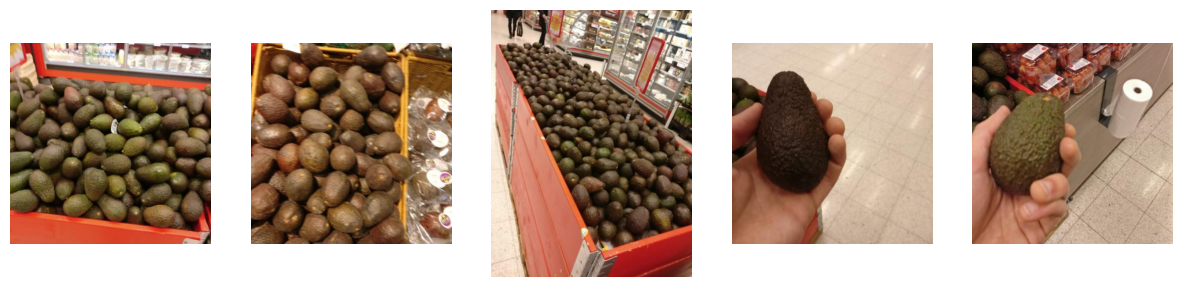

Sizes of images respectively:[(348, 348), (348, 348), (348, 464), (348, 348), (348, 348)]


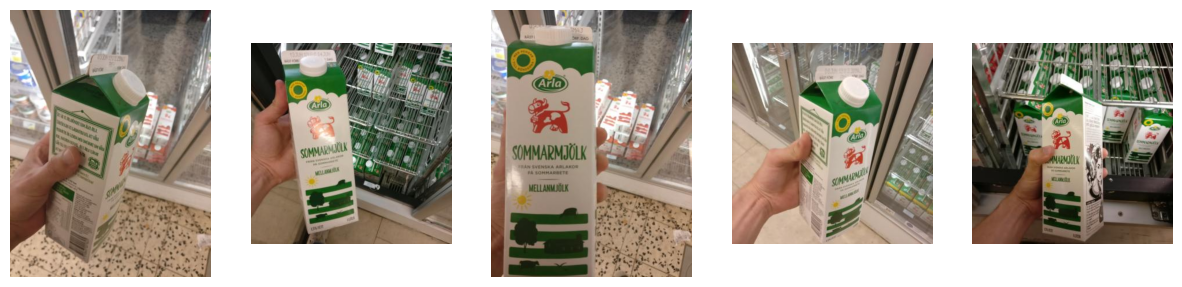

Sizes of images respectively:[(348, 464), (348, 348), (348, 464), (348, 348), (348, 348)]


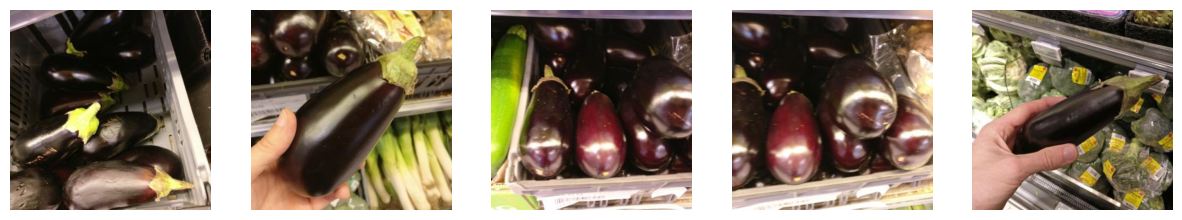

Sizes of images respectively:[(348, 348), (348, 348), (348, 348), (348, 348), (348, 348)]


In [7]:
num_samples = 5
sizes = visualize_samples_from_folder("GroceryStoreDataset/dataset/train/Fruit/Avocado", num_samples=num_samples)
print(f"Sizes of images respectively:{sizes}")

sizes = visualize_samples_from_folder("GroceryStoreDataset/dataset/train/Packages/Milk/Arla-Medium-Fat-Milk/", num_samples=num_samples)
print(f"Sizes of images respectively:{sizes}")

sizes = visualize_samples_from_folder("GroceryStoreDataset/dataset/train/Vegetables/Aubergine/", num_samples=num_samples)
print(f"Sizes of images respectively:{sizes}")

As we can see, the images have different shapes. So we need to resize them all to a fixed shape, which we will do through **Transformers**.

The **simple_T** defined below is a simple set of transformers, including rescaling and normalizing 

In [7]:
simple_T = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

The variable **num_classes** contains the number of classes in the dataset

In [8]:
num_classes = GroceryStoreDataset(split='train', transform=simple_T).get_num_classes()
num_classes

43

## Save the work
Here the variable **all_models** is used to save the results for later processings and visualizations.

In [10]:
all_models = {}

## Part1

### First try
we have implemented a very simple model consisting of one Convolution layer, one Activation layer, one Pooling layer, and finally one Fully-Connected layer. Below we have pointed out the reason why each layer is used in this model (and perhaps in later models) :
* **Convolutional layer** for extracting the features
* **Activation Function layer** to add some non-linearity
* **Pooling** for sub-sampling and dimensionality reduction
* **Fully-Connected layer** to classify the extracted features

The model, with ~9 million parameter, ended up showing an obvious overfitting and maximum validation accuracy of **25.68%**. The validation accuracy related to best validation loss was also **25.68%**.

In [21]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 112 * 112, num_classes)

    def forward(self, x):
        x = self.pool(F.relu((self.conv1(x))))
        x = x.view(-1, 16 * 112 * 112)
        x = self.fc(x)
        return x

In [22]:
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [23]:
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Linear-3                   [-1, 43]       8,630,315
Total params: 8,630,763
Trainable params: 8,630,763
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.66
Params size (MB): 32.92
Estimated Total Size (MB): 41.15
----------------------------------------------------------------


In [24]:
train_loader, val_loader, _ = get_data_loaders(train_transform=simple_T, val_test_transform=simple_T)

In [25]:
model_save_path='simpleCNN.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,  # train with enhanced data
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/20], Train Loss: 22.3536, Train Acc: 0.2621, Val Loss: 6.0567, Val Acc: 0.1554
Epoch [2/20], Train Loss: 0.4930, Train Acc: 0.8701, Val Loss: 4.6961, Val Acc: 0.2162
Epoch [3/20], Train Loss: 0.0822, Train Acc: 0.9837, Val Loss: 5.0582, Val Acc: 0.2297
Epoch [4/20], Train Loss: 0.0178, Train Acc: 0.9992, Val Loss: 5.3175, Val Acc: 0.2264
Epoch [5/20], Train Loss: 0.0080, Train Acc: 1.0000, Val Loss: 5.2325, Val Acc: 0.2365
Epoch [6/20], Train Loss: 0.0054, Train Acc: 1.0000, Val Loss: 5.3013, Val Acc: 0.2297
Epoch [7/20], Train Loss: 0.0040, Train Acc: 1.0000, Val Loss: 5.3578, Val Acc: 0.2297
Epoch [8/20], Train Loss: 0.0032, Train Acc: 1.0000, Val Loss: 5.3950, Val Acc: 0.2331
Epoch [9/20], Train Loss: 0.0026, Train Acc: 1.0000, Val Loss: 5.4302, Val Acc: 0.2297
Epoch [10/20], Train Loss: 0.0022, Train Acc: 1.0000, Val Loss: 5.4637, Val Acc: 0.2331
Epoch [11/20], Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 5.4817, Val Acc: 0.2365
Epoch [12/20], Train L

In [26]:
_, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum loss, with accuracy of {(best_val_accuracy*100):.2f}% for the validation set')

At epoch 2, We reached minimum loss, with accuracy of 21.62% for the validation set


Plot the results

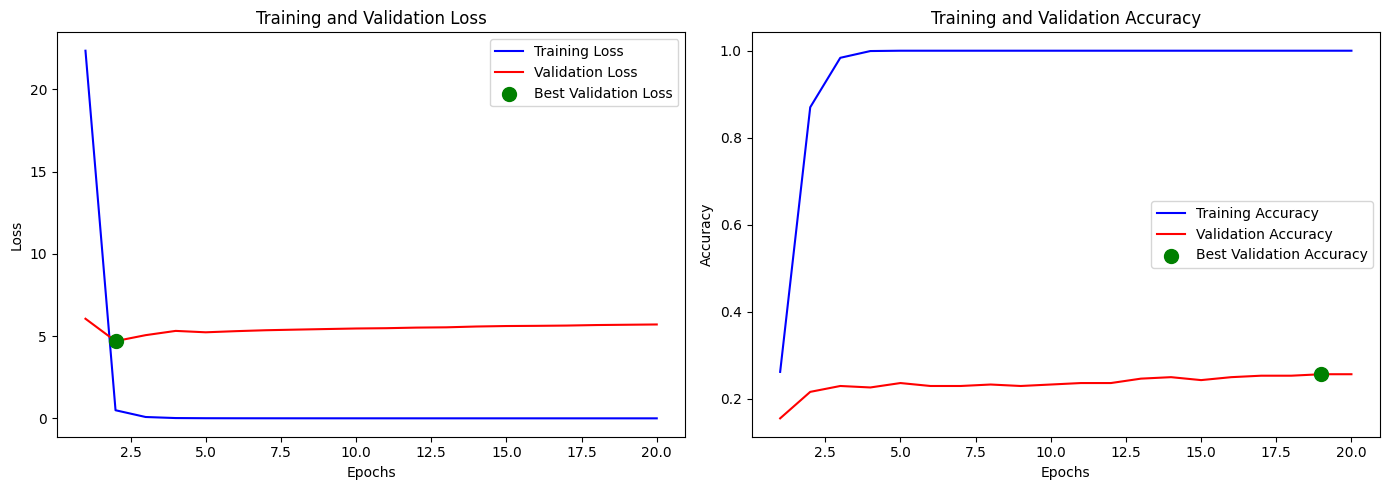

In [27]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

save the results

In [28]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model1'
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

#### Data augementation
The first approach taken to tackle the overfitting happend before, is data augementation. This step is done with a more complex set of transformers in **enhanced_T**, applied only to the training data, and including rescaling, fliping, shearing and cropping.

With the same model, we reached a maximum validation accuracy of **32.43%** and validation accuracy of **26.69%** for best validation loss, however, the overfitting is still there

In [29]:
enhanced_T = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),                                         
    T.RandomAffine(degrees=0, shear=0.2),                                
    T.RandomApply([T.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.5), 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [30]:
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [21]:
## The same model is used here
#summary(model, input_size=(3, 224, 224), device=str(device))

In [31]:
train_loader, val_loader, _ = get_data_loaders(train_transform=enhanced_T, val_test_transform=simple_T)

In [32]:
model_save_path='simpleCNN_2.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,  # train with enhanced data
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/20], Train Loss: 20.2369, Train Acc: 0.2148, Val Loss: 4.7918, Val Acc: 0.1959
Epoch [2/20], Train Loss: 1.7885, Train Acc: 0.5292, Val Loss: 4.4936, Val Acc: 0.2095
Epoch [3/20], Train Loss: 1.3000, Train Acc: 0.6511, Val Loss: 4.2943, Val Acc: 0.2669
Epoch [4/20], Train Loss: 1.0129, Train Acc: 0.7288, Val Loss: 4.1419, Val Acc: 0.2297
Epoch [5/20], Train Loss: 0.8146, Train Acc: 0.7811, Val Loss: 4.6211, Val Acc: 0.2736
Epoch [6/20], Train Loss: 0.6012, Train Acc: 0.8318, Val Loss: 4.2770, Val Acc: 0.2905
Epoch [7/20], Train Loss: 0.6569, Train Acc: 0.8178, Val Loss: 4.9781, Val Acc: 0.3074
Epoch [8/20], Train Loss: 0.4872, Train Acc: 0.8614, Val Loss: 4.9479, Val Acc: 0.3209
Epoch [9/20], Train Loss: 0.4406, Train Acc: 0.8712, Val Loss: 5.0296, Val Acc: 0.3007
Epoch [10/20], Train Loss: 0.4293, Train Acc: 0.8735, Val Loss: 5.3635, Val Acc: 0.3243
Epoch [11/20], Train Loss: 0.4047, Train Acc: 0.8860, Val Loss: 4.8357, Val Acc: 0.2905
Epoch [12/20], Train L

In [24]:
_, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum loss, with accuracy of {(best_val_accuracy*100):.2f}% for the validation set')

At epoch 3, We reached minimum loss, with accuracy of 26.69% for the validation set


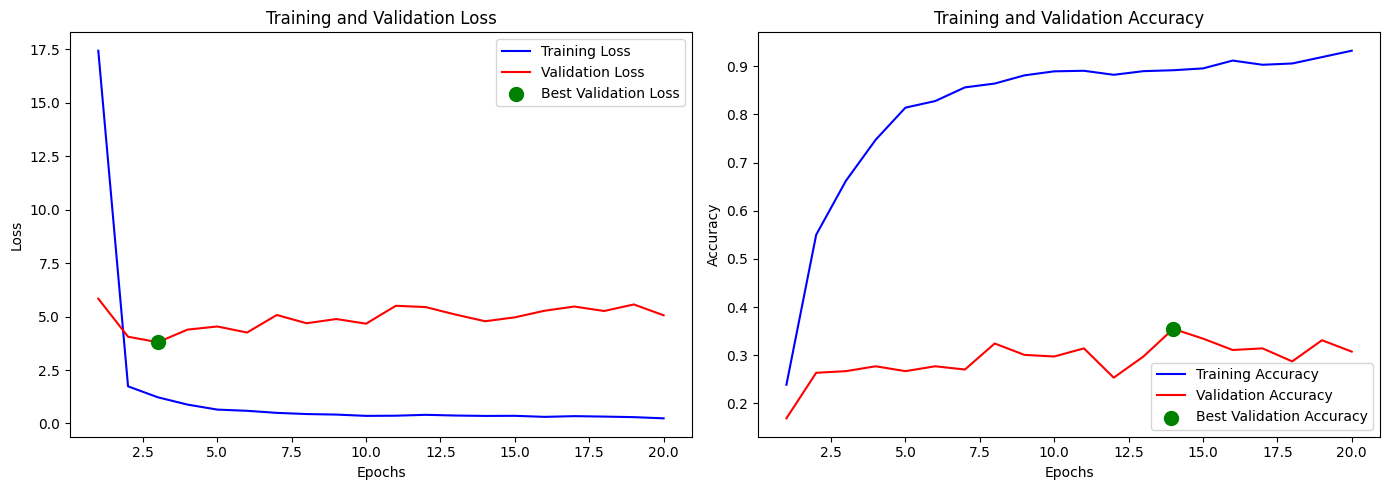

In [25]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [34]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model2'
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

#### Changing some setting of training process that could reduce overfitting
In this step, a number of settings has changed:
* **AdamW** is used instead of **Adam** for the optimizer. As suggested in this [article](https://towardsdatascience.com/why-adamw-matters-736223f31b5d), with AdamW the weights will be updated adaptively and further regularized by the weight_decay factor
* The **StepLR** scheduler reduces the learning rate by multiplying it by the *gamma* every *step_size* epochs
* The total possible number of epochs are increased, however a **early stopping** is considered to avoid further computations in case of no improvement

With the same model, we reached a maximum validation accuracy of **33.45%** and validation accuracy of **31.76%** for best validation loss. Overall, the results are improved. The overfitting is still there, however the plots are bit smoother than before, which could indicate that the changes implemented in this section were positive

In [14]:
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 30
patience = 7

In [28]:
## Still the same model
#summary(model, input_size=(3, 224, 224), device=str(device))

In [15]:
model_save_path='simpleCNN_3.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,  # train with enhanced data
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            scheduler=scheduler,
                                                            patience=7,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/30], Train Loss: 3.9588, Train Acc: 0.2409, Val Loss: 4.0383, Val Acc: 0.1622
Epoch [2/30], Train Loss: 2.2336, Train Acc: 0.4561, Val Loss: 3.5714, Val Acc: 0.2061
Epoch [3/30], Train Loss: 1.5286, Train Acc: 0.5758, Val Loss: 3.3810, Val Acc: 0.2365
Epoch [4/30], Train Loss: 1.2376, Train Acc: 0.6383, Val Loss: 3.4739, Val Acc: 0.2466
Epoch [5/30], Train Loss: 0.9477, Train Acc: 0.7110, Val Loss: 3.4076, Val Acc: 0.2365
Epoch [6/30], Train Loss: 0.8170, Train Acc: 0.7473, Val Loss: 3.2247, Val Acc: 0.2601
Epoch [7/30], Train Loss: 0.6682, Train Acc: 0.8008, Val Loss: 3.3787, Val Acc: 0.2466
Epoch [8/30], Train Loss: 0.4351, Train Acc: 0.8777, Val Loss: 2.9499, Val Acc: 0.3007
Epoch [9/30], Train Loss: 0.3765, Train Acc: 0.8981, Val Loss: 2.9441, Val Acc: 0.2939
Epoch [10/30], Train Loss: 0.3513, Train Acc: 0.9080, Val Loss: 2.9401, Val Acc: 0.3007
Epoch [11/30], Train Loss: 0.3683, Train Acc: 0.9015, Val Loss: 2.9273, Val Acc: 0.3142
Epoch [12/30], Train Lo

In [16]:
_, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum loss, with accuracy of {(best_val_accuracy*100):.2f}% for the validation set')

At epoch 15, We reached minimum loss, with accuracy of 31.76% for the validation set


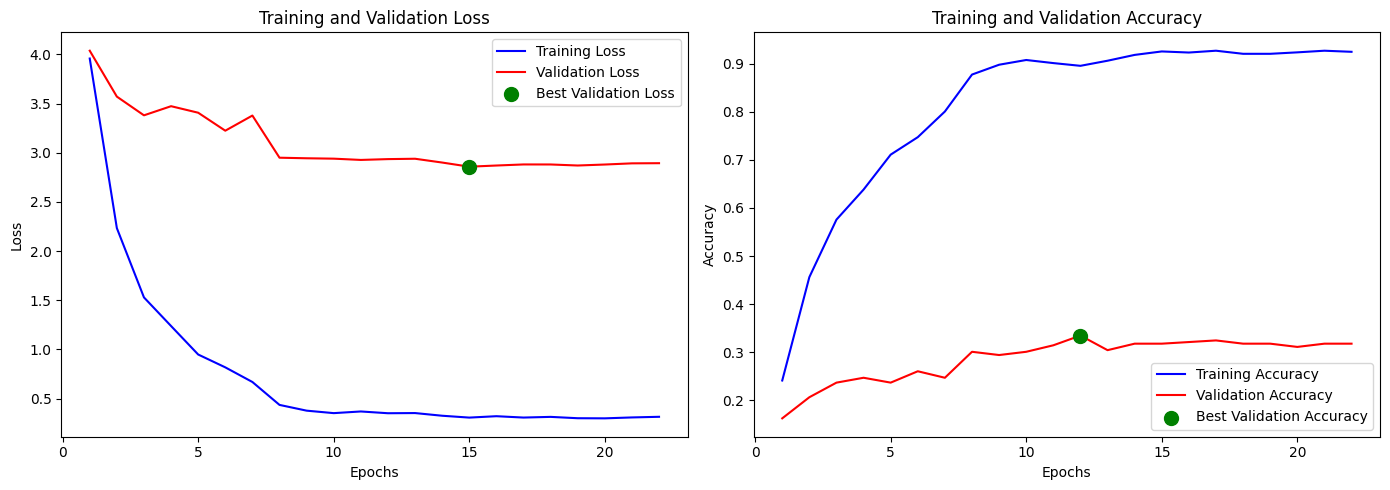

In [17]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [19]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model3'
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

We can see that the overfitting still exists, and approaches like *batch-norm* or *dropout* layers are known to address this issue. However, since the maximum validation accuracy we have reached so far is **far from 60%**, we are not going implement the mentioned approches because it is very **unlikely** that they could increase the current val accuracy up to 60%

### Second try: Adding residual layers

The **Plateaus** in the loss and accuracy plots in previous segment can indicate that the model is struggling to learn additional meaningful features and may benefit from an architectural adjustment. Residual blocks could help by allowing the network to build on previously learned features rather than re-learning them from scratch, supporting deeper representations and potentially enabling the model to move past the plateau. To put this into test, we have build the new model **SimpleCNN_Res**. Let's see the changes in this new model:
* **The residual block**: added for the purpose of *incremental learning* 
* **Global Average Pooling**: reduces the number of parameters in FC layers which could increase generalization 
* **Batch normalization**: added both after the FC layers, and to the convolutional layer for better regularization

The results were promising. The new model with **~9 thousand parameters** caused the validation accuracy to rise up to **41.55%**, and validation accuracy for best loss to **41.22%**. It could be said that the problem now turned into underfitting since the training accuracy decreased to around **62%**.

In [36]:
class SimpleCNN_Res(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_Res, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(16)

        self.res_block1 = self.__get_residual_layer(16, 16, downsample=False)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(16, 64)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_classes)

    def __get_residual_layer(self, in_channels, out_channels, downsample=False):
        stride = 2 if downsample else 1
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Apply the residual block with matching dimensions
        residual = x
        x = F.relu(self.res_block1(x) + residual)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten for fully connected layers

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)

        return x

In [37]:
model = SimpleCNN_Res(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 30
patience = 7

In [38]:
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]           2,320
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]           2,320
       BatchNorm2d-8         [-1, 16, 112, 112]              32
 AdaptiveAvgPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 64]           1,088
      BatchNorm1d-11                   [-1, 64]             128
           Linear-12                   [-1, 43]           2,795
Total params: 9,195
Trainable params: 9,195
Non-trainable params: 0
-----------------------------------

In [39]:
model_save_path='SimpleCNN_Residual.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            scheduler=scheduler,
                                                            patience=7,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/30], Train Loss: 3.1076, Train Acc: 0.2133, Val Loss: 2.9779, Val Acc: 0.1858
Epoch [2/30], Train Loss: 2.4554, Train Acc: 0.3527, Val Loss: 2.7289, Val Acc: 0.1791
Epoch [3/30], Train Loss: 2.1080, Train Acc: 0.4155, Val Loss: 2.5312, Val Acc: 0.2939
Epoch [4/30], Train Loss: 1.8978, Train Acc: 0.4322, Val Loss: 2.5886, Val Acc: 0.2432
Epoch [5/30], Train Loss: 1.7480, Train Acc: 0.4564, Val Loss: 2.6781, Val Acc: 0.2534
Epoch [6/30], Train Loss: 1.5915, Train Acc: 0.5049, Val Loss: 2.1919, Val Acc: 0.3547
Epoch [7/30], Train Loss: 1.4973, Train Acc: 0.5405, Val Loss: 2.3046, Val Acc: 0.3311
Epoch [8/30], Train Loss: 1.3440, Train Acc: 0.5890, Val Loss: 2.0858, Val Acc: 0.3919
Epoch [9/30], Train Loss: 1.3131, Train Acc: 0.6019, Val Loss: 2.0679, Val Acc: 0.3682
Epoch [10/30], Train Loss: 1.2892, Train Acc: 0.6076, Val Loss: 2.0950, Val Acc: 0.3750
Epoch [11/30], Train Loss: 1.2876, Train Acc: 0.6061, Val Loss: 2.0761, Val Acc: 0.3784
Epoch [12/30], Train Lo

Let's also see the validation accuracy where we got the minimum loss

In [ ]:
min_loss, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum validation loss of {(min_loss):.2f}, with validation accuracy of {(best_val_accuracy*100):.2f}%')

At epoch 18, We reached minimum validation loss of 1.95, with validation accuracy of 41.22%


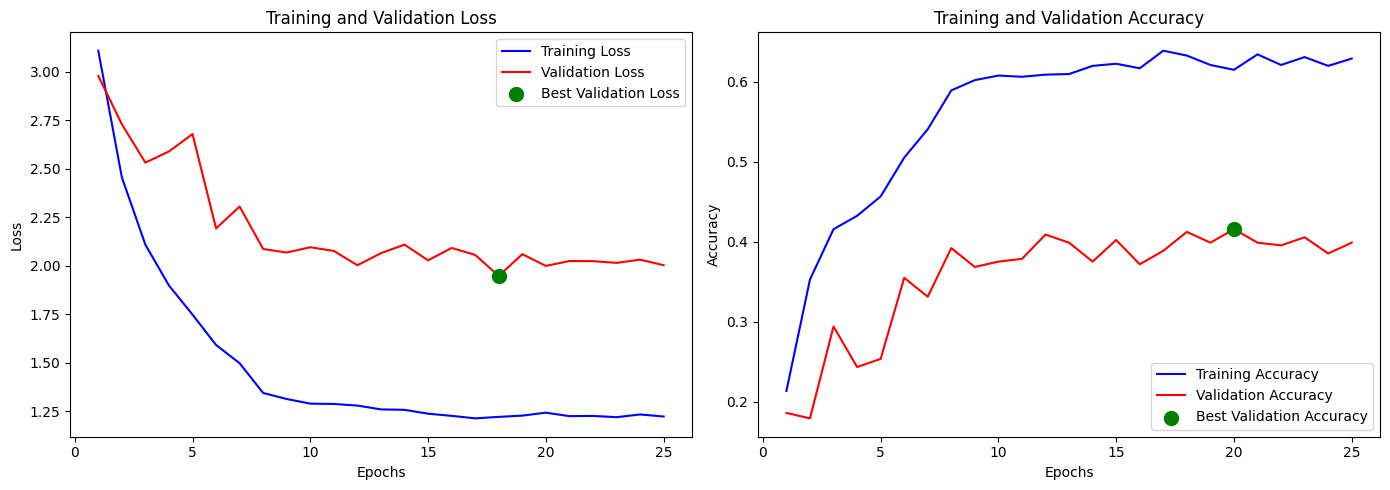

In [41]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [55]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model4'
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

### 3.Adding more layers
To address the underfitting occured in the previous segment, we have build a new model with more convolutional layers. One thing that is worth mentioning is that the residual layer makes it much safer to add new layers due to the effect of mitigating the vanishing gradient problem

The new model with **~434 thousand parameters**, reached maximum validation accuracy of **61.15%**, which was also the validation accuracy for best validation loss. Something very clear in the plots are the flactuations, which could be due to the high value of the learning rate, **1e-3**, in the early stages of training. However, as schedular have done its work, the plots have became much more stable.

In [45]:
class FinalCNN(nn.Module):
    def __init__(self, num_classes):
        super(FinalCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.res_block1 = self.__get_residual_layer(128, 128)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(128, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)

    def __get_residual_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Apply the residual block with matching dimensions
        residual = x
        x = F.relu(self.res_block1(x) + residual)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten for fully connected layers

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)

        return x

In [46]:
model = FinalCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 30
patience = 7

In [47]:
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]         147,584
      BatchNorm2d-11          [-1, 128, 28, 28]             256
             ReLU-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]         147,584
      BatchNorm2d-14          [-1, 128,

In [86]:
model_save_path='FinalCNN.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            scheduler=scheduler,
                                                            patience=7,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/30], Train Loss: 2.4510, Train Acc: 0.3307, Val Loss: 2.4708, Val Acc: 0.2703
Epoch [2/30], Train Loss: 1.6620, Train Acc: 0.4909, Val Loss: 2.1298, Val Acc: 0.3378
Epoch [3/30], Train Loss: 1.3125, Train Acc: 0.5898, Val Loss: 2.1931, Val Acc: 0.2736
Epoch [4/30], Train Loss: 1.0551, Train Acc: 0.6708, Val Loss: 1.9801, Val Acc: 0.4054
Epoch [5/30], Train Loss: 0.9376, Train Acc: 0.7076, Val Loss: 1.7439, Val Acc: 0.5101
Epoch [6/30], Train Loss: 0.8309, Train Acc: 0.7292, Val Loss: 2.0337, Val Acc: 0.4088
Epoch [7/30], Train Loss: 0.6602, Train Acc: 0.8027, Val Loss: 2.4276, Val Acc: 0.4223
Epoch [8/30], Train Loss: 0.4671, Train Acc: 0.8811, Val Loss: 1.6440, Val Acc: 0.5709
Epoch [9/30], Train Loss: 0.4083, Train Acc: 0.9004, Val Loss: 1.4765, Val Acc: 0.5946
Epoch [10/30], Train Loss: 0.3929, Train Acc: 0.9053, Val Loss: 1.5078, Val Acc: 0.5709
Epoch [11/30], Train Loss: 0.3754, Train Acc: 0.9011, Val Loss: 1.5050, Val Acc: 0.5743
Epoch [12/30], Train Lo

In [ ]:
min_loss, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum validation loss of {(min_loss):.2f}, with validation accuracy of {(best_val_accuracy*100):.2f}%')

At epoch 19, We reached minimum validation loss of 1.38, with validation accuracy of 61.15%


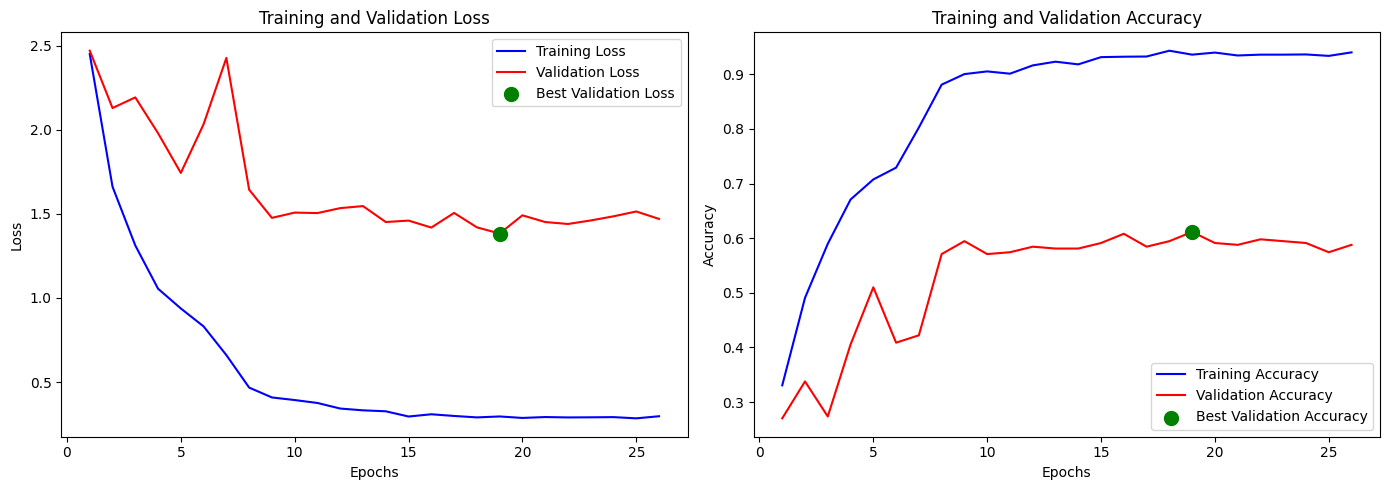

In [87]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [56]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model5'
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

### Visualizing the performances on validation and test sets
We are going to evaluate the performance of the saved models on test-set as well. It is important to make sure the saved models are evaluated on same test-set, which is not seen by any of the models. In other words, **Data leakage** should not happen, otherwise the evaluation results are useless.

In this notebook, We have called *get_data_loaders* multiple times. Every time the grouping and arrangment of items in data loaders(train, validation and test) changes. But, the overall items in each data loader does not change since they are from a specific *split* in *GroceryStoreDataset*

In [ ]:
_, _, test_loader = get_data_loaders(train_transform=simple_T, val_test_transform=simple_T)

sorted_names = sorted(all_models.keys(), key=lambda x: int(x[5:]))
model_list = [
    SimpleCNN(num_classes=num_classes),       # model1
    SimpleCNN(num_classes=num_classes),       # model2
    SimpleCNN(num_classes=num_classes),       # model3
    SimpleCNN_Res(num_classes=num_classes),   # model4
    FinalCNN(num_classes=num_classes)         # model5
    ]

performance = {}
for model_name, model in zip(sorted_names, model_list):
    result = evaluate_model(
        model=model,
        model_name=all_models[model_name]['save_path'],
        test_loader=test_loader,
        print_result=False
        )

    performance[model_name] = {'test_accuracy':result, 'val_accuracy':all_models[model_name]['max_val']}

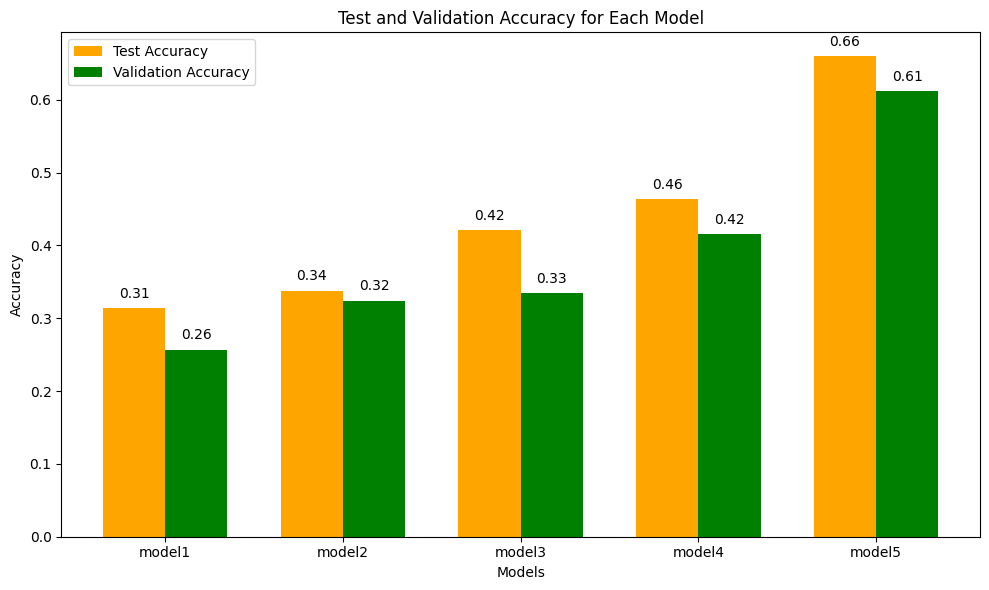

In [74]:
plot_performance_histogram(performance)

## Part 2: fine-tune an existing network

The prerequisites

In [6]:
simple_T = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

num_classes = GroceryStoreDataset(split='train', transform=simple_T).get_num_classes()

enhanced_T = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),                                         
    T.RandomAffine(degrees=0, shear=0.2),                                
    T.RandomApply([T.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.5), 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader, val_loader, _ = get_data_loaders(train_transform=enhanced_T, val_test_transform=simple_T)

all_models = {}

def get_model():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

### Section1
Fine-tuninig the Resnet-18 with the same training hyperparameters used for the best model in the first part of the assignment

The model with **~22 thousand trainable parameters**, reached maximum validation accuracy of **73.65%**, and validation accuracy of **71.96%** for best loss

In [8]:
model = get_model().to(device)

for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [9]:
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [10]:
# The hyperparameters used for the best model of part 1
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 30
patience = 7

In [11]:
model_save_path='resnet18-v1.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            scheduler=scheduler,
                                                            patience=patience,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/30], Train Loss: 2.3849, Train Acc: 0.3924, Val Loss: 1.9105, Val Acc: 0.4662
Epoch [2/30], Train Loss: 1.1948, Train Acc: 0.7261, Val Loss: 1.4458, Val Acc: 0.5608
Epoch [3/30], Train Loss: 0.7776, Train Acc: 0.8394, Val Loss: 1.1651, Val Acc: 0.6554
Epoch [4/30], Train Loss: 0.5597, Train Acc: 0.9114, Val Loss: 1.0521, Val Acc: 0.6791
Epoch [5/30], Train Loss: 0.4273, Train Acc: 0.9345, Val Loss: 0.9495, Val Acc: 0.7027
Epoch [6/30], Train Loss: 0.3686, Train Acc: 0.9409, Val Loss: 0.9704, Val Acc: 0.6892
Epoch [7/30], Train Loss: 0.3215, Train Acc: 0.9447, Val Loss: 0.9177, Val Acc: 0.6892
Epoch [8/30], Train Loss: 0.2659, Train Acc: 0.9708, Val Loss: 0.8851, Val Acc: 0.7162
Epoch [9/30], Train Loss: 0.2529, Train Acc: 0.9659, Val Loss: 0.8798, Val Acc: 0.7128
Epoch [10/30], Train Loss: 0.2503, Train Acc: 0.9720, Val Loss: 0.8706, Val Acc: 0.7230
Epoch [11/30], Train Loss: 0.2478, Train Acc: 0.9682, Val Loss: 0.8610, Val Acc: 0.7365
Epoch [12/30], Train Lo

In [13]:
min_loss, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum validation loss of {(min_loss):.2f}, with validation accuracy of {(best_val_accuracy*100):.2f}%')

At epoch 12, We reached minimum validation loss of 0.86, with validation accuracy of 71.96%


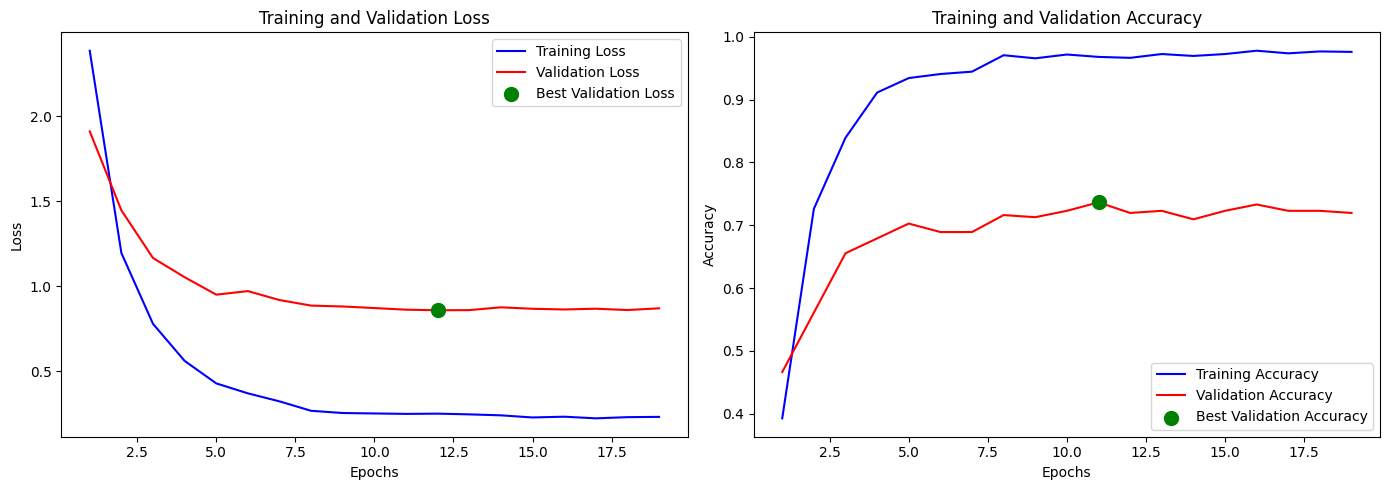

In [14]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [15]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model1' 
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

### Section2
Tweak the training hyperparameters in order to increase the accuracy on the validation split

In this section, we are going to do multiple attempts to improve validation accuracy

#### Attempt 1

In the previous section, the plots are somehow getting flattened from epoch 7 or 8 afterwards. In this attempt, we have written a custom schedular which sets the learning rate to **1e-3 for the first 7 epoch**, for validation accuracy to reach around 70% in a shorter time, and then to **1e-4** to explore for the local minima with less speed

The metrics improved. We got **75.68%** at the same epoch of maximum validation accuracy and minimum loss values. The best validation loss also reduced to **0.79** which is a positive thing. However, the plots are demonstrating a very slow improvement slope for both accuracy and loss. 

In [19]:
model = get_model().to(device)

for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
def lr_lambda(epoch):
    return 1.0 if epoch < 8 else 0.1

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
num_epochs = 50

In [21]:
model_save_path='resnet18-v2.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            scheduler=scheduler,
                                                            # patience=patience,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/50], Train Loss: 2.4195, Train Acc: 0.3977, Val Loss: 1.9099, Val Acc: 0.4932
Epoch [2/50], Train Loss: 1.1793, Train Acc: 0.7458, Val Loss: 1.4299, Val Acc: 0.5473
Epoch [3/50], Train Loss: 0.7753, Train Acc: 0.8530, Val Loss: 1.2453, Val Acc: 0.6014
Epoch [4/50], Train Loss: 0.5481, Train Acc: 0.9068, Val Loss: 1.0300, Val Acc: 0.6926
Epoch [5/50], Train Loss: 0.4262, Train Acc: 0.9292, Val Loss: 1.0017, Val Acc: 0.6993
Epoch [6/50], Train Loss: 0.3798, Train Acc: 0.9364, Val Loss: 0.9999, Val Acc: 0.6959
Epoch [7/50], Train Loss: 0.3178, Train Acc: 0.9458, Val Loss: 0.9447, Val Acc: 0.6959
Epoch [8/50], Train Loss: 0.2561, Train Acc: 0.9682, Val Loss: 0.8966, Val Acc: 0.7196
Epoch [9/50], Train Loss: 0.2546, Train Acc: 0.9712, Val Loss: 0.8784, Val Acc: 0.7061
Epoch [10/50], Train Loss: 0.2527, Train Acc: 0.9644, Val Loss: 0.8773, Val Acc: 0.7331
Epoch [11/50], Train Loss: 0.2435, Train Acc: 0.9742, Val Loss: 0.8884, Val Acc: 0.7297
Epoch [12/50], Train Lo

In [22]:
min_loss, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum validation loss of {(min_loss):.2f}, with validation accuracy of {(best_val_accuracy*100):.2f}%')

At epoch 48, We reached minimum validation loss of 0.79, with validation accuracy of 75.68%


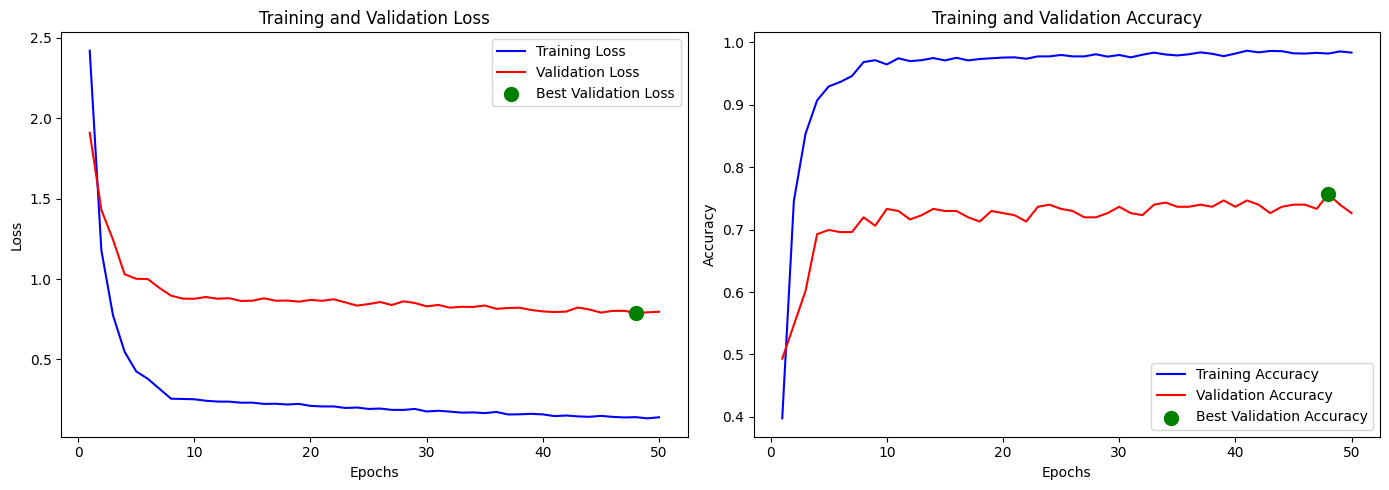

In [23]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [24]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model2' 
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

#### Attempt 2
In this attempt we have set batch-size to **64**. Larger batches provide more stable and averaged gradient estimates, which can make the model’s updates smoother. This stability can prevent the model from fitting to small fluctuations in the data, which is often a source of overfitting. The learning rate is also increased as it was suggested in many articles, when batch-size in increased.

Once again the results improved. We reached maximum validation accuracy of **78.04%**, and validation accuracy of **77.70%** for the best validation loss. The best validation loss also improved to **0.72**

In [29]:
train_loader, val_loader, test_loader = get_data_loaders(train_transform=enhanced_T, val_test_transform=simple_T, batch_size=64)

In [30]:
model = get_model().to(device)

for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3)
num_epochs = 50

In [32]:
model_save_path='resnet18-v2-64batch.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            # scheduler=scheduler,
                                                            # patience=patience,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/50], Train Loss: 2.7366, Train Acc: 0.3019, Val Loss: 2.1844, Val Acc: 0.4358
Epoch [2/50], Train Loss: 1.5100, Train Acc: 0.6447, Val Loss: 1.5832, Val Acc: 0.6047
Epoch [3/50], Train Loss: 0.9988, Train Acc: 0.8038, Val Loss: 1.3592, Val Acc: 0.6216
Epoch [4/50], Train Loss: 0.7258, Train Acc: 0.8750, Val Loss: 1.1991, Val Acc: 0.6791
Epoch [5/50], Train Loss: 0.5647, Train Acc: 0.9106, Val Loss: 1.1344, Val Acc: 0.6892
Epoch [6/50], Train Loss: 0.4904, Train Acc: 0.9292, Val Loss: 1.0846, Val Acc: 0.6824
Epoch [7/50], Train Loss: 0.4179, Train Acc: 0.9299, Val Loss: 0.9857, Val Acc: 0.7162
Epoch [8/50], Train Loss: 0.3496, Train Acc: 0.9542, Val Loss: 0.9308, Val Acc: 0.7297
Epoch [9/50], Train Loss: 0.3003, Train Acc: 0.9655, Val Loss: 0.9204, Val Acc: 0.7264
Epoch [10/50], Train Loss: 0.2700, Train Acc: 0.9689, Val Loss: 0.9385, Val Acc: 0.7399
Epoch [11/50], Train Loss: 0.2396, Train Acc: 0.9754, Val Loss: 0.8879, Val Acc: 0.7432
Epoch [12/50], Train Lo

In [ ]:
min_loss, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum validation loss of {(min_loss):.2f}, with validation accuracy of {(best_val_accuracy*100):.2f}%')

At epoch 30, We reached minimum validation loss of 0.72, with validation accuracy of 77.70%


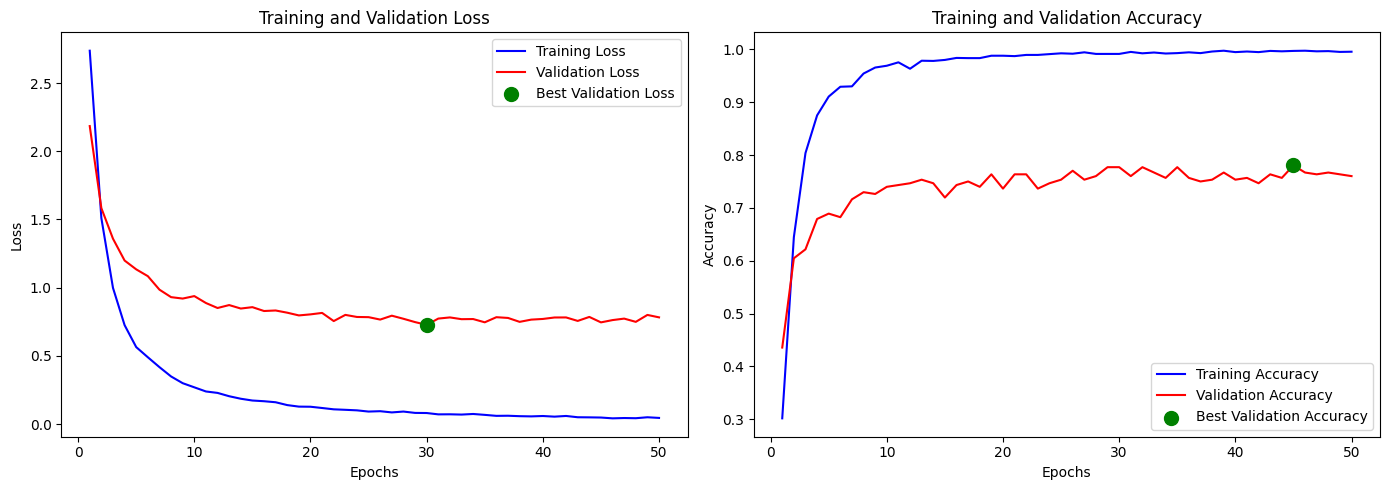

In [33]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [ ]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model3' 
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

#### Attempt 3
In this attempt, we have once again added the *weight decay* parameter to the optimizer, as to reduce the overfitting in previous plots

The results in general were not good. We reached **78.38%** for maximum validation accuracy, and **78.04%** for best validation loss. These numbers are better than the previous attemp. However, the best validation loss was higher than before, and since loss has been our main metric for choosing and saving the best model, this attempt can not be considered a successful one. 

In [17]:
train_loader, val_loader, test_loader = get_data_loaders(train_transform=enhanced_T, val_test_transform=simple_T, batch_size=64)

In [18]:
model = get_model().to(device)

for name, param in model.named_parameters():
    if 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
num_epochs = 50

In [20]:
model_save_path='resnet18-v2-64-wdc.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            # scheduler=scheduler,
                                                            # patience=patience,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/50], Train Loss: 2.7297, Train Acc: 0.2981, Val Loss: 2.2627, Val Acc: 0.4054
Epoch [2/50], Train Loss: 1.4922, Train Acc: 0.6701, Val Loss: 1.7264, Val Acc: 0.5304
Epoch [3/50], Train Loss: 0.9852, Train Acc: 0.8023, Val Loss: 1.4427, Val Acc: 0.5473
Epoch [4/50], Train Loss: 0.7312, Train Acc: 0.8773, Val Loss: 1.2563, Val Acc: 0.6520
Epoch [5/50], Train Loss: 0.5730, Train Acc: 0.9072, Val Loss: 1.1379, Val Acc: 0.6453
Epoch [6/50], Train Loss: 0.4793, Train Acc: 0.9261, Val Loss: 1.0858, Val Acc: 0.6824
Epoch [7/50], Train Loss: 0.4002, Train Acc: 0.9455, Val Loss: 1.0729, Val Acc: 0.6858
Epoch [8/50], Train Loss: 0.3594, Train Acc: 0.9511, Val Loss: 0.9735, Val Acc: 0.7230
Epoch [9/50], Train Loss: 0.3062, Train Acc: 0.9652, Val Loss: 0.9609, Val Acc: 0.6791
Epoch [10/50], Train Loss: 0.2788, Train Acc: 0.9640, Val Loss: 0.9312, Val Acc: 0.7162
Epoch [11/50], Train Loss: 0.2486, Train Acc: 0.9670, Val Loss: 0.9119, Val Acc: 0.7162
Epoch [12/50], Train Lo

In [22]:
min_loss, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum validation loss of {(min_loss):.2f}, with validation accuracy of {(best_val_accuracy*100):.2f}%')

At epoch 47, We reached minimum validation loss of 0.73, with validation accuracy of 78.04%


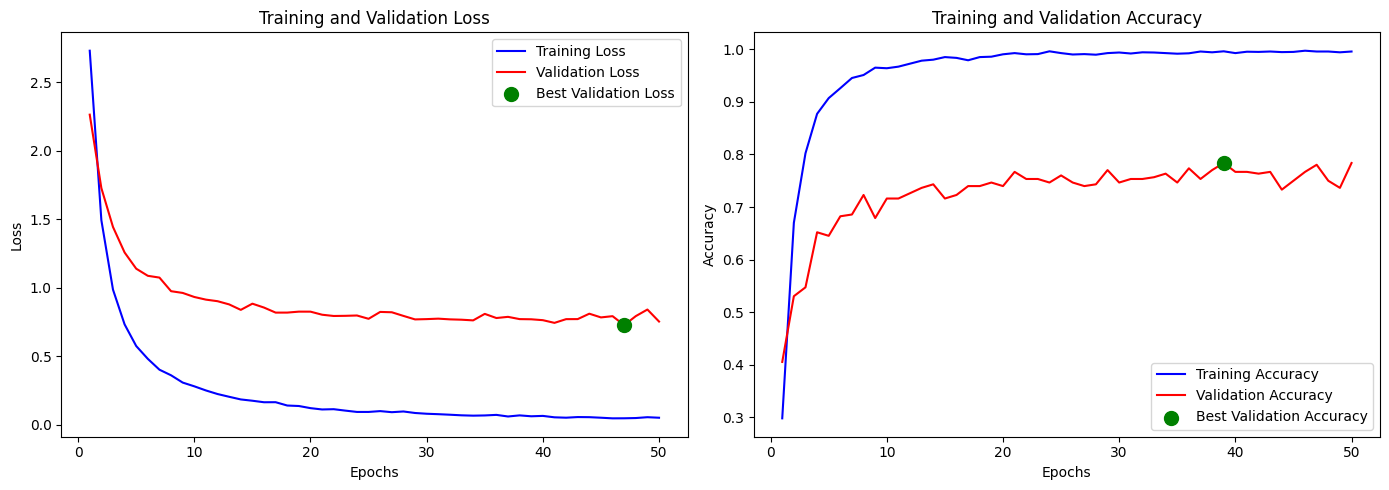

In [23]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [ ]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model4' 
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

#### Attempt 4
Finally we decided to let go of only training the fully-connected layer, and we unfreezed the whole **layer4**. One reason was this [article](https://arxiv.org/abs/1411.1792), which suggests that in transfer learning, pretrained layers often contain feature representations that may not perfectly fit the target dataset, especially if it's quite different from the source dataset (e.g., ImageNet). By unfreezing certain layers, the model can better adapt to the specific characteristics of the new data.

We have set batch-size once again to 32, and the learning rate is set to 1e-5(a smaller number than before).

The final results were so much better. We reached the highest validation accuracy of **86.49%** and lowest validation loss of **0.48** both at the last epoch. 

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(train_transform=enhanced_T, val_test_transform=simple_T, batch_size=32)

In [15]:
def get_model():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze all of layer4
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Unfreeze the fully connected layer
    for param in model.fc.parameters():
        param.requires_grad = True
    
    return model

model = get_model().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 50

In [17]:
model_save_path='resnet18-v3.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                            model=model,
                                                            train_loader=train_loader,
                                                            val_loader=val_loader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            # scheduler=scheduler,
                                                            # patience=patience,
                                                            num_epochs=num_epochs,
                                                            model_save_path=model_save_path)

print("="*40)
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

Start of training
Epoch [1/50], Train Loss: 3.4207, Train Acc: 0.1583, Val Loss: 3.0147, Val Acc: 0.2703
Epoch [2/50], Train Loss: 2.4984, Train Acc: 0.4655, Val Loss: 2.5044, Val Acc: 0.3750
Epoch [3/50], Train Loss: 1.9652, Train Acc: 0.5803, Val Loss: 2.1944, Val Acc: 0.4595
Epoch [4/50], Train Loss: 1.6049, Train Acc: 0.6773, Val Loss: 1.9836, Val Acc: 0.5034
Epoch [5/50], Train Loss: 1.3441, Train Acc: 0.7360, Val Loss: 1.7885, Val Acc: 0.5507
Epoch [6/50], Train Loss: 1.1385, Train Acc: 0.7894, Val Loss: 1.6347, Val Acc: 0.5946
Epoch [7/50], Train Loss: 0.9589, Train Acc: 0.8428, Val Loss: 1.4950, Val Acc: 0.6284
Epoch [8/50], Train Loss: 0.8257, Train Acc: 0.8689, Val Loss: 1.3915, Val Acc: 0.6453
Epoch [9/50], Train Loss: 0.7074, Train Acc: 0.8958, Val Loss: 1.3029, Val Acc: 0.6757
Epoch [10/50], Train Loss: 0.6268, Train Acc: 0.9186, Val Loss: 1.2056, Val Acc: 0.7196
Epoch [11/50], Train Loss: 0.5292, Train Acc: 0.9375, Val Loss: 1.1416, Val Acc: 0.7162
Epoch [12/50], Train Lo

In [20]:
min_loss, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum validation loss of {(min_loss):.2f}, with validation accuracy of {(best_val_accuracy*100):.2f}%')

At epoch 50, We reached minimum validation loss of 0.48, with validation accuracy of 86.49%


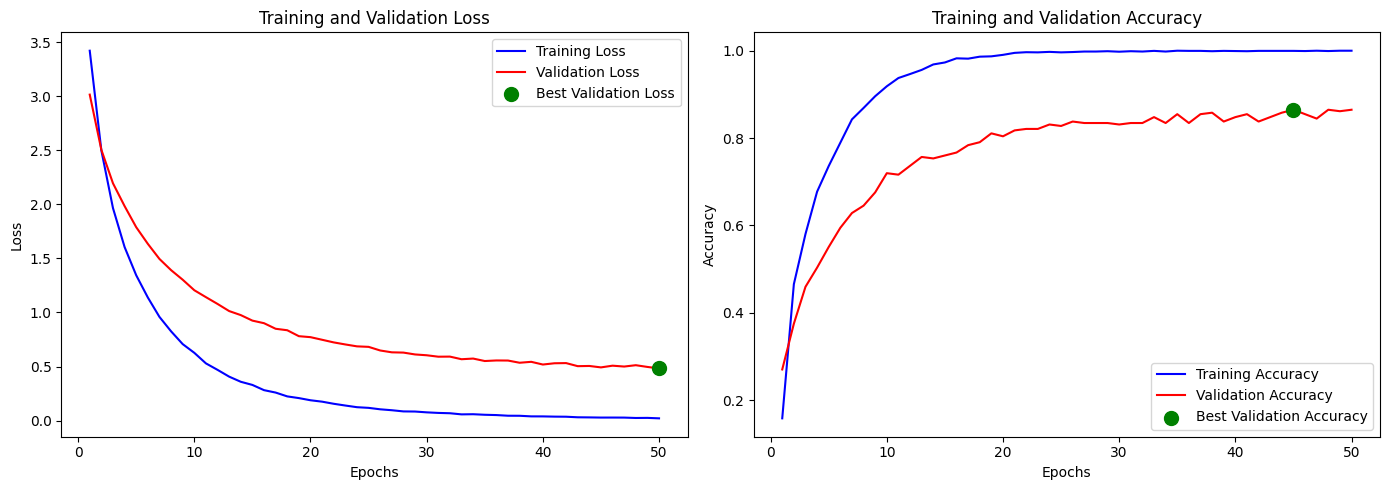

In [21]:
plot_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [ ]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model5' 
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

#### Last attempt
Since the plots of the metrics in the previous attempt seem to be on the slope of improvement, we will load the previously saved model(which was ironically saved at the last epoch of the previous attempt), and then train it for a few more epochs

The results were good. We reached a better validation accuracy of **88.51**, and a better validation loss of **0.41**

In [26]:
def load_the_resnet(resnet) :
    model_name = resnet
    state_dict = torch.load(model_name)

    model = get_model()
    for name, param in model.named_parameters():
        if 'layer4' in name or 'fc' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    model.load_state_dict(state_dict)
    return model

In [25]:
train_loader, val_loader, _ = get_data_loaders(train_transform=enhanced_T, val_test_transform=simple_T, batch_size=32)

In [ ]:
model = load_the_resnet(resnet="resnet18-v3.pth").to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-5)
num_epochs = 7

model_save_path='resnet18-v3-more-epoch.pth'

print("="*40)
print('Start of training')
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
                                                                                model=model,
                                                                                train_loader=train_loader,
                                                                                val_loader=val_loader,
                                                                                criterion=criterion,
                                                                                optimizer=optimizer,
                                                                                num_epochs=num_epochs,
                                                                                model_save_path=model_save_path)

print("="*40)

Start of training
Epoch [1/7], Train Loss: 0.0108, Train Acc: 0.9992, Val Loss: 0.4399, Val Acc: 0.8649
Epoch [2/7], Train Loss: 0.0093, Train Acc: 1.0000, Val Loss: 0.4290, Val Acc: 0.8615
Epoch [3/7], Train Loss: 0.0089, Train Acc: 1.0000, Val Loss: 0.4283, Val Acc: 0.8716
Epoch [4/7], Train Loss: 0.0079, Train Acc: 0.9996, Val Loss: 0.4413, Val Acc: 0.8581
Epoch [5/7], Train Loss: 0.0074, Train Acc: 1.0000, Val Loss: 0.4136, Val Acc: 0.8851
Epoch [6/7], Train Loss: 0.0066, Train Acc: 1.0000, Val Loss: 0.4325, Val Acc: 0.8682
Epoch [7/7], Train Loss: 0.0070, Train Acc: 1.0000, Val Loss: 0.4230, Val Acc: 0.8682


In [29]:
max_val, max_epoch = find_max_and_index(val_acc_history)
print(f'At epoch {max_epoch}, We reached maximum accuracy of {(max_val*100):.2f}% for the validation set')

At epoch 5, We reached maximum accuracy of 88.51% for the validation set


In [30]:
min_loss, best_epoch = find_min_and_index(val_loss_history)
best_val_accuracy =  val_acc_history[best_epoch-1]
print(f'At epoch {best_epoch}, We reached minimum validation loss of {(min_loss):.2f}, with validation accuracy of {(best_val_accuracy*100):.2f}%')

At epoch 5, We reached minimum validation loss of 0.41, with validation accuracy of 88.51%


In [ ]:
results = {}
history = train_loss_history, train_acc_history, val_loss_history, val_acc_history 

name = 'model6' 
results['history']   = history
results['max_val']   = max_val
results['save_path'] = model_save_path

all_models[name] = results

### Visualizing the performances on validation and test sets

In [40]:
def get_initial_resnet():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    for name, param in model.named_parameters():
        if 'fc' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model


def get_secondary_resnet():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    for param in model.parameters():
        param.requires_grad = False
    
    for param in model.layer4.parameters():
        param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True
    
    return model


In [41]:
_, _, test_loader = get_data_loaders(train_transform=enhanced_T, val_test_transform=simple_T, batch_size=32)
sorted_names = sorted(all_models.keys(), key=lambda x: int(x[5:]))
model_list = [
    get_initial_resnet(),       # model1
    get_initial_resnet(),       # model2
    get_initial_resnet(),       # model3
    get_initial_resnet(),       # model4
    get_secondary_resnet(),     # model5
    get_secondary_resnet()      # model6
    ]

performance = {}
for model_name, model in zip(sorted_names, model_list):
    result = evaluate_model(
        model=model,
        model_name=all_models[model_name]['save_path'],
        test_loader=test_loader,
        print_result=False
        )

    performance[model_name] = {'test_accuracy':result, 'val_accuracy':all_models[model_name]['max_val']}

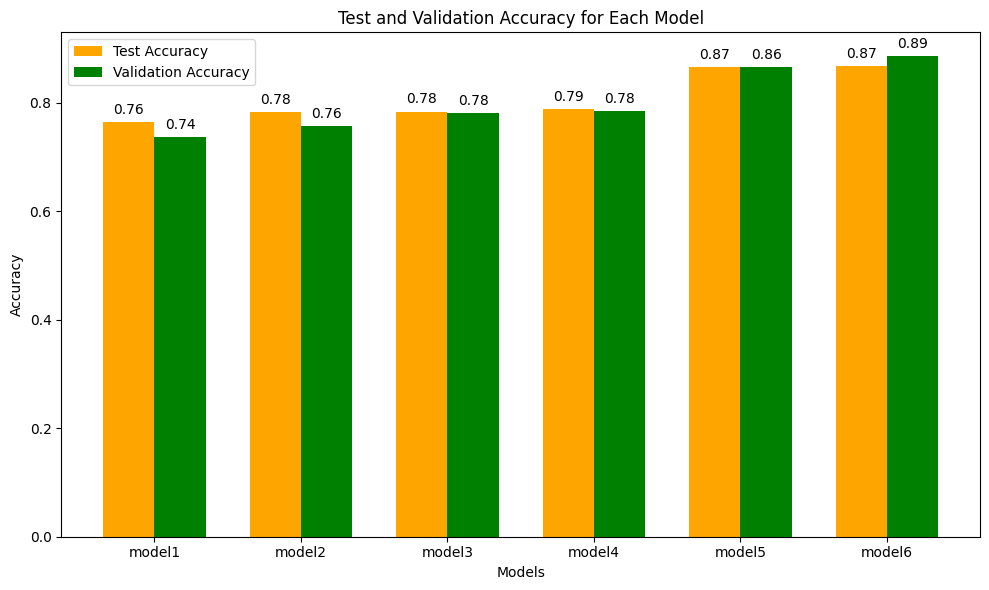

In [42]:
plot_performance_histogram(performance)

Let's see between *model5* and *model6*, which one has actually done better on test set

In [45]:
performance['model5']['test_accuracy'] > performance['model6']['test_accuracy']

False

Then the last model, **model6**, has the best performance on both validation and test sets